In [52]:
from itertools import product
from functools import lru_cache
import os

from nimare.generate import create_coordinate_dataset
from nimare.meta.ale import ALE
from nimare.meta.mkda import KDA, MKDADensity
from nimare.meta.kernel import KDAKernel, ALEKernel, MKDAKernel
from nimare.correct import FDRCorrector, FWECorrector

import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed


In [46]:
@lru_cache(maxsize=None)
def create_dsets(n_dsets, **kwargs):
    return [create_coordinate_dataset(seed=seed, **kwargs)[1] for seed in range(n_dsets)]


In [66]:
N_DSET = 100
NOISE_FOCI = 30
N_JOBS = os.cpu_count()

In [67]:
# create 100 datasets with random coordinates

noise_datasets = create_dsets(N_DSET, foci=0, n_noise_foci=NOISE_FOCI)

In [68]:
# set up the meta analysis estimators
metas = [
    ('ale', ALE),
    ('mkda', MKDADensity),
]

null_methods = [
    {'null_method': 'analytic'},
    {'null_method': 'empirical'},
]

fit_dset_args = list(product(metas, noise_datasets, null_methods))

def fit_dset(meta_tuple, dset, kwargs):
    res = meta_tuple[1](**kwargs).fit(dset)
    p_map = res.get_map("p", return_type="array")
    fpr = (p_map < 0.05).sum() / p_map.shape[0]
    return meta_tuple[0], kwargs['null_method'], fpr, p_map


In [69]:
estimator_results = Parallel(n_jobs=N_JOBS)(delayed(fit_dset)(*args) for args in fit_dset_args)

In [70]:
estimator_collector = {'meta': [], 'null_method': [], "fpr": [], "p_array": []}
for res in estimator_results:
    estimator_collector['meta'].append(res[0])
    estimator_collector['null_method'].append(res[1])
    estimator_collector['fpr'].append(res[2])
    estimator_collector['p_array'].append(res[3])

In [71]:
estimator_df = pd.DataFrame(estimator_collector)

In [9]:
# correlate the p-value arrays of each meta analysis estimator with each other
# to identify the relationship between meta analysis estimators 
meta_p_correlations = np.array([
    np.corrcoef([meta_arr['ale'][idx], meta_arr['kda'][idx], meta_arr['mkda'][idx]]) for idx in range(len(meta_arr['ale']))
])

In [10]:
ale_kda_corr = meta_p_correlations[:, 0, 1]
ale_mkda_corr = meta_p_correlations[:, 0, 2]
kda_mkda_corr = meta_p_correlations[:, 1, 2]

In [11]:
df_corr = pd.DataFrame({'ale_kda': ale_kda_corr, 'ale_mkda': ale_mkda_corr, 'kda_mkda': kda_mkda_corr})
df_fpr = pd.DataFrame(meta_fpr).melt(var_name="meta_estimator", value_name="false_positive_rate")

In [62]:
estimator_df.query("(meta != 'mkda') & (null_method != 'analytic')")

,meta,null_method,fpr,p_array
1,ale,empirical,0.060796,"[0.7193, 0.5844, 0.5874, 0.6755, 0.6372, 0.620..."
3,ale,empirical,0.061492,"[0.9507, 0.9716, 0.9858, 0.9861, 0.9954, 0.987..."
5,ale,empirical,0.060975,"[0.8952, 0.9298, 0.972, 0.7605999999999999, 0...."
7,ale,empirical,0.058979,"[0.9998, 0.9998, 0.9987, 0.9999, 0.9999, 0.999..."
9,ale,empirical,0.062858,"[0.7657, 0.8683, 0.927, 0.6604, 0.7443, 0.7464..."
...,...,...,...,...
191,ale,empirical,0.059343,"[0.9431, 0.9853, 0.9937, 0.9177, 0.9892, 0.734..."
193,ale,empirical,0.056436,"[0.9317, 0.9855, 0.9946, 0.7584, 0.9497, 0.385..."
195,ale,empirical,0.057106,"[0.9387, 0.9414, 0.9374, 0.9301, 0.92080000000..."
197,ale,empirical,0.056195,"[0.9838, 0.9667, 0.9317, 0.9855, 0.9792, 0.994..."


Text(0.5, 1.0, 'False Positive Rates for Meta Analysis Estimators')

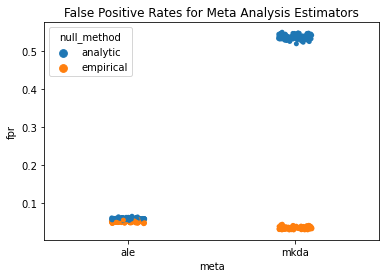

In [73]:
fig = sns.stripplot(data=estimator_df, x='meta', hue='null_method', y='fpr')
fig.set_title("False Positive Rates for Meta Analysis Estimators")

Text(0.5, 1.0, 'Correlations of p-value arrays between Meta Analysis Estimators')

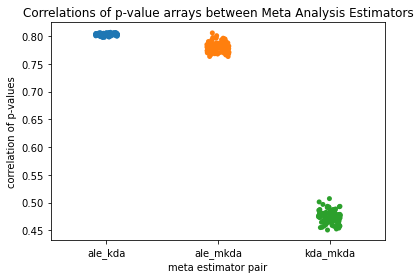

In [13]:
fig = sns.stripplot(data=df_corr)
fig.set_ylabel("correlation of p-values")
fig.set_xlabel("meta estimator pair")
fig.set_title("Correlations of p-value arrays between Meta Analysis Estimators")